Simulacion de compra y venta

In [1]:
try:
    import yfinance as yf, numpy as np, pandas as pd, matplotlib.pyplot as plt
    import quantstats as qs
    qs.extend_pandas()
except:
    %pip install QuantStats
    import yfinance as yf, numpy as np, pandas as pd, matplotlib.pyplot as plt
    import quantstats as qs
    qs.extend_pandas()

n_sigma = 40
n_obv =100

n_rsi = 15
fast, slow = 20, 60

data= yf.download('TSLA', auto_adjust=True, progress=False, start='2011-01-01', end='2020-12-31')

data['Balance'] = np.where(data.Close>data.Close.shift(), data['Volume'], np.where(data.Close < data.Close.shift(), -data['Volume'], 0))

data['OBV']= data['Balance'].cumsum()

dif= data['Close'].diff()

win=pd.DataFrame(np.where(dif>0, dif, 0), index=data.index) 
loss = pd.DataFrame(np.where(dif<0, abs(dif), 0), index=data.index)

ema_win = win.ewm(alpha=1/n_rsi).mean()

ema_loss = loss.ewm(alpha=1/n_rsi).mean()

rs=ema_win/ema_loss

#Features

data['cruce'] = data.Close.rolling (fast).mean() /data.Close.rolling (slow).mean() -1

data['rsi'] = 100-(100 / (1+rs))

data['sigma'] = data.Close.pct_change().rolling(n_sigma).std()

data['OBV_osc'] = (data.OBV - data.OBV.rolling(n_obv).mean()) / (data.OBV.rolling (n_obv).std())

features = data.iloc[:,-4:].dropna()

features

,cruce,rsi,sigma,OBV_osc
Date,,,,
2011-05-25,0.066759,60.657673,0.039441,2.154925
2011-05-26,0.066522,62.525054,0.039414,2.737019
2011-05-27,0.066726,62.790004,0.029056,2.922802
2011-05-31,0.068359,65.022974,0.028402,3.334472
2011-06-01,0.069083,55.266055,0.029319,2.884899
...,...,...,...,...
2020-12-23,0.247179,60.972636,0.041372,1.655826
2020-12-24,0.246281,63.025737,0.040430,1.692907
2020-12-28,0.245130,63.277421,0.040462,1.757391


In [2]:
gatillos_compra = pd.DataFrame(index = features.index)

gatillos_compra['cruce']= np.where(features.cruce> 0, True, False)

gatillos_compra['rsi']= np.where(features.rsi > 65, True, False)
gatillos_compra['sigma'] =np.where(features.sigma > 0.01, True, False) 
mascara_compra = gatillos_compra.all(axis=1)

mascara_compra.sum(), mascara_compra.count()

gatillos_venta=pd.DataFrame(index = features.index)

gatillos_venta['cruce'] = np.where(features.cruce< -0.01, True, False)
gatillos_venta['rsi']= np.where(features.rsi < 55, True, False) 
gatillos_venta['oby'] = np.where(features. OBV_osc > 0, True, False) 
mascara_venta = gatillos_venta.all(axis=1)

mascara_venta.sum(), mascara_venta.count()

(113, 2417)

Tabla de acciones

In [3]:
data.dropna (inplace=True) 

data['gatillo']= np.where(mascara_compra, 'compra', np.where(mascara_venta, 'venta', ''))
actions= data.loc[data.gatillo !=''].copy() 
actions['gatillo']= np.where(actions.gatillo != actions.gatillo.shift(), actions.gatillo, "")

actions=actions.loc[actions.gatillo !=''].copy() 

actions

,Open,High,Low,Close,Volume,Balance,OBV,cruce,rsi,sigma,OBV_osc,gatillo
Date,,,,,,,,,,,,
2011-05-31,1.979333,2.018667,1.970000,2.009333,49357500,49357500,355998000,0.068359,65.022974,0.028402,3.334472,compra
2012-01-18,1.779333,1.792000,1.750000,1.787333,18903000,18903000,240532500,-0.083017,44.723743,0.047041,0.003865,venta
2012-02-15,2.206667,2.294000,2.151333,2.240000,41427000,41427000,381957000,0.009988,66.937212,0.044627,2.782804,compra
2013-11-11,9.400000,9.694667,9.140000,9.646667,209964000,209964000,3686403000,-0.021696,37.997816,0.041509,0.003973,venta
2014-01-16,10.833333,11.513333,10.826667,11.398000,179391000,179391000,4445892000,0.028473,66.157934,0.044273,1.297222,compra
2014-04-22,13.757333,14.622000,13.667333,14.576000,147070500,147070500,4608324000,-0.017390,53.431156,0.037299,0.163592,venta
2014-06-16,13.784000,15.032667,13.750667,14.974000,198696000,198696000,4576902000,0.000109,66.662111,0.032350,-0.343382,compra
2014-10-15,14.666667,15.399333,14.488000,15.313333,137209500,137209500,5009941500,-0.021526,35.642463,0.027298,0.073664,venta
2015-04-24,14.700000,14.720000,14.534000,14.562000,36417000,-36417000,4194966000,0.003621,65.505544,0.021731,-0.452249,compra


In [4]:
if actions.iloc[0].loc['gatillo'] == 'venta':
    actions = actions.iloc[1:]
if actions.iloc[-1].loc['gatillo'] == 'compra':
    actions = actions.iloc[:-1]
actions

,Open,High,Low,Close,Volume,Balance,OBV,cruce,rsi,sigma,OBV_osc,gatillo
Date,,,,,,,,,,,,
2011-05-31,1.979333,2.018667,1.970000,2.009333,49357500,49357500,355998000,0.068359,65.022974,0.028402,3.334472,compra
2012-01-18,1.779333,1.792000,1.750000,1.787333,18903000,18903000,240532500,-0.083017,44.723743,0.047041,0.003865,venta
2012-02-15,2.206667,2.294000,2.151333,2.240000,41427000,41427000,381957000,0.009988,66.937212,0.044627,2.782804,compra
2013-11-11,9.400000,9.694667,9.140000,9.646667,209964000,209964000,3686403000,-0.021696,37.997816,0.041509,0.003973,venta
2014-01-16,10.833333,11.513333,10.826667,11.398000,179391000,179391000,4445892000,0.028473,66.157934,0.044273,1.297222,compra
2014-04-22,13.757333,14.622000,13.667333,14.576000,147070500,147070500,4608324000,-0.017390,53.431156,0.037299,0.163592,venta
2014-06-16,13.784000,15.032667,13.750667,14.974000,198696000,198696000,4576902000,0.000109,66.662111,0.032350,-0.343382,compra
2014-10-15,14.666667,15.399333,14.488000,15.313333,137209500,137209500,5009941500,-0.021526,35.642463,0.027298,0.073664,venta
2015-04-24,14.700000,14.720000,14.534000,14.562000,36417000,-36417000,4194966000,0.003621,65.505544,0.021731,-0.452249,compra


Tabla de trades

In [5]:
pares = actions.iloc[::2].loc[:,['Close']].reset_index()
impares = actions.iloc[1::2].loc[:,['Close']].reset_index()
trades = pd.concat([pares,impares],axis=1)
trades

,Date,Close,Date,Close
0,2011-05-31,2.009333,2012-01-18,1.787333
1,2012-02-15,2.240000,2013-11-11,9.646667
2,2014-01-16,11.398000,2014-04-22,14.576000
3,2014-06-16,14.974000,2014-10-15,15.313333
4,2015-04-24,14.562000,2015-08-18,17.381332
5,2016-03-17,15.092000,2016-05-20,14.685333
6,2016-12-23,14.222667,2017-07-26,22.923332
7,2017-09-15,25.320667,2017-10-24,22.489332
8,2018-01-22,23.437332,2019-01-14,22.293333
9,2019-07-12,16.338667,2020-03-23,28.952667


In [6]:
CT=0

trades.columns = ['fecha_compra', 'px_compra', 'fecha_venta','px_venta'] 

trades['rendimiento'] = trades.px_venta / trades.px_compra - 1

trades['rendimiento'] -=CT

trades['dias'] = (trades.fecha_venta - trades.fecha_compra).dt.days
if len(trades):
    trades['resultado']= np.where(trades['rendimiento' ] > 0, 'Ganador', 'Perdedor')
    trades['rendimientoAcumulado'] = (trades['rendimiento']+1).cumprod()-1

trades

,fecha_compra,px_compra,fecha_venta,px_venta,rendimiento,dias,resultado,rendimientoAcumulado
0,2011-05-31,2.009333,2012-01-18,1.787333,-0.110484,232,Perdedor,-0.110484
1,2012-02-15,2.240000,2013-11-11,9.646667,3.306548,635,Ganador,2.830741
2,2014-01-16,11.398000,2014-04-22,14.576000,0.278821,96,Ganador,3.898832
3,2014-06-16,14.974000,2014-10-15,15.313333,0.022661,121,Ganador,4.009847
4,2015-04-24,14.562000,2015-08-18,17.381332,0.193609,116,Ganador,4.979797
5,2016-03-17,15.092000,2016-05-20,14.685333,-0.026946,64,Perdedor,4.818667
6,2016-12-23,14.222667,2017-07-26,22.923332,0.611746,215,Ganador,8.378215
7,2017-09-15,25.320667,2017-10-24,22.489332,-0.111819,39,Perdedor,7.329551
8,2018-01-22,23.437332,2019-01-14,22.293333,-0.048811,357,Perdedor,6.922978
9,2019-07-12,16.338667,2020-03-23,28.952667,0.772034,255,Ganador,13.039783


Refactorizo

In [7]:
def getData(ticker, data_from, data_to):

    data = yf.download(ticker, auto_adjust=True, progress=False, start=data_from, end=data_to)
    return data

def getFeatures(data, n_obv = 100, n_sigma = 40, n_rsi = 15, fast=20, slow = 60): 
    
    data['Balance'] = np.where(data.Close>data.Close.shift(), data['Volume'], np.where(data.Close < data.Close.shift(), -data['Volume'], 0))

    data['OBV']= data['Balance'].cumsum()

    dif= data['Close'].diff()

    win=pd.DataFrame(np.where(dif>0, dif, 0), index=data.index) 
    loss = pd.DataFrame(np.where(dif<0, abs(dif), 0), index=data.index)

    ema_win = win.ewm(alpha=1/n_rsi).mean()

    ema_loss = loss.ewm(alpha=1/n_rsi).mean()

    rs=ema_win/ema_loss

    #Features

    data['cruce'] = data.Close.rolling (fast).mean() /data.Close.rolling (slow).mean() -1

    data['rsi'] = 100-(100 / (1+rs))

    data['sigma'] = data.Close.pct_change().rolling(n_sigma).std()

    data['OBV_osc'] = (data.OBV - data.OBV.rolling(n_obv).mean()) / (data.OBV.rolling (n_obv).std())

    features = data.iloc[:,-4:].dropna()

    return features

In [8]:
def getActions(features,trig_buy_cross=0,trig_buy_rsi=65, trig_buy_sigma=0.01,
               trig_sell_cross=-0.01,trig_sell_rsi=55, trig_sell_obv=0):
    
    gatillos_compra = pd.DataFrame(index = features.index)

    gatillos_compra['cruce']= np.where(features.cruce> trig_buy_cross, True, False)

    gatillos_compra['rsi']= np.where(features.rsi > trig_buy_rsi, True, False)
    gatillos_compra['sigma'] =np.where(features.sigma >trig_buy_sigma, True, False) 
    mascara_compra = gatillos_compra.all(axis=1)

    mascara_compra.sum(), mascara_compra.count()

    gatillos_venta=pd.DataFrame(index = features.index)

    gatillos_venta['cruce'] = np.where(features.cruce< trig_sell_cross, True, False)
    gatillos_venta['rsi']= np.where(features.rsi < trig_sell_rsi, True, False) 
    gatillos_venta['obv'] = np.where(features. OBV_osc > trig_sell_obv, True, False) 
    mascara_venta = gatillos_venta.all(axis=1)

    mascara_venta.sum(), mascara_venta.count()
    data.dropna (inplace=True) 

    data['gatillo']= np.where(mascara_compra, 'compra', np.where(mascara_venta, 'venta', ''))
    actions= data.loc[data.gatillo !=''].copy() 
    actions['gatillo']= np.where(actions.gatillo != actions.gatillo.shift(), actions.gatillo, "")

    actions=actions.loc[actions.gatillo !=''].copy() 

    if actions.iloc[0].loc['gatillo'] == 'venta':
        actions = actions.iloc[1:]
    if actions.iloc[-1].loc['gatillo'] == 'compra':
        actions = actions.iloc[:-1]
    return actions
    

In [9]:
def getTrades(actions):
    pares = actions.iloc[::2].loc[:,['Close']].reset_index()
    impares = actions.iloc[1::2].loc[:,['Close']].reset_index()
    trades = pd.concat([pares,impares],axis=1)
    trades
    CT=0

    trades.columns = ['fecha_compra', 'px_compra', 'fecha_venta','px_venta'] 

    trades['rendimiento'] = trades.px_venta / trades.px_compra - 1

    trades['rendimiento'] -=CT

    trades['dias'] = (trades.fecha_venta - trades.fecha_compra).dt.days
    if len(trades):
        trades['resultado']= np.where(trades['rendimiento' ] > 0, 'Ganador', 'Perdedor')
        trades['rendimientoAcumulado'] = (trades['rendimiento']+1).cumprod()-1

    return trades

In [10]:
data = getData(ticker='SOL-USD',data_from='2021-01-01',data_to='2023-05-05')
features = getFeatures(data,n_obv=100,n_sigma=40,n_rsi=15,fast=20,slow=60)
actions = getActions(features,0,65,0.01,-0.01,55,0)
trades= getTrades(actions)
actions

,Open,High,Low,Close,Volume,Balance,OBV,cruce,rsi,sigma,OBV_osc,gatillo
Date,,,,,,,,,,,,
2021-04-10,27.649712,28.257971,25.963226,26.841404,270235258,-270235258,5783083722,0.326094,75.714686,0.060006,2.824403,compra
2021-06-08,38.251270,42.478291,33.685459,41.517815,1786996802,1786996802,6060079453,-0.084445,54.468581,0.126526,0.630628,venta
2021-08-10,38.678810,41.660908,38.223171,40.639797,452480699,452480699,12798024397,0.022062,66.064997,0.056798,1.938023,compra
2021-12-11,167.916626,173.898483,161.860001,171.949493,1877844189,1877844189,59955946341,-0.019469,37.640150,0.054764,0.051441,venta
2022-04-01,122.736107,137.558411,118.787910,134.430939,4434807484,4434807484,61659742039,0.019407,78.185669,0.051168,2.595570,compra
2022-05-02,89.672058,90.693367,85.407219,87.581017,1265220129,-1265220129,49786056813,-0.011761,37.935862,0.049619,0.743969,venta
2023-01-14,18.287506,24.565018,18.266825,24.249458,3399684035,3399684035,34970177141,0.019986,86.125704,0.076351,1.147983,compra
2023-03-13,20.310793,21.340412,18.964472,20.433712,1161164364,1161164364,30720241773,-0.063792,47.079302,0.047082,0.291374,venta


Resultados

In [11]:
trades.groupby('resultado').size()

resultado
Ganador     2
Perdedor    2
dtype: int64

In [12]:
trades.groupby('resultado').mean()

/tmp/ipykernel_106802/3628090046.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trades.groupby('resultado').mean()


,px_compra,px_venta,rendimiento,dias,rendimientoAcumulado
resultado,,,,,
Ganador,33.740601,106.733654,1.888922,91.0,3.045657
Perdedor,79.340199,54.007364,-0.252930,44.5,2.928270


In [13]:
trades.groupby('resultado').describe().dias

,count,mean,std,min,25%,50%,75%,max
resultado,,,,,,,,
Ganador,2.0,91.0,45.254834,59.0,75.00,91.0,107.00,123.0
Perdedor,2.0,44.5,19.091883,31.0,37.75,44.5,51.25,58.0


In [14]:
def resumen(trades):
    if len(trades):
        resultado = float(trades.iloc[-1].rendimientoAcumulado-1) 
        agg_cant= trades.groupby('resultado').size()
        agg_rend = trades.groupby('resultado').mean()['rendimiento'] 
        agg_tiempos = trades.groupby('resultado').sum()['dias'] 
        agg_tiempos_medio = trades.groupby("resultado").mean()['dias']

        r = pd.concat([agg_cant, agg_rend, agg_tiempos, agg_tiempos_medio], axis=1) 
        r.columns = ['Cantidad', 'Rendimiento x Trade', 'Dias Total', 'Dias x Trade']
        resumen = r.T

        try:
            t_win = r['Dias Total']['Ganador']
        except:
            t_win = 0

        try:
            t_loss = r['Dias Total']['Perdedor']
        except:
            t_loss = 0

        t = t_win + t_loss

        tea = (resultado +1)*(365/t)-1 if t> 0 else 0

        metricas  ={'rendimiento':round(resultado,4), 'dias in':round(t,4), 'TEA':round(tea,4)}


    else:
        resumen = pd.DataFrame()
        metricas = {'rendimiento' :0, 'dias_in':0, 'TEA':0}

    return resumen, metricas

In [15]:
resumen(trades)

/tmp/ipykernel_106802/3195340741.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_rend = trades.groupby('resultado').mean()['rendimiento']
/tmp/ipykernel_106802/3195340741.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_tiempos = trades.groupby('resultado').sum()['dias']
/tmp/ipykernel_106802/3195340741.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_tiempos_medio = trades.groupby("resultado").me

(resultado               Ganador  Perdedor
 Cantidad               2.000000   2.00000
 Rendimiento x Trade    1.888922  -0.25293
 Dias Total           182.000000  89.00000
 Dias x Trade          91.000000  44.50000,
 {'rendimiento': 1.5928, 'dias in': 271, 'TEA': 2.4922})

In [16]:
def eventDriveLong(df): 
    df["pct_change"]=df['Close'].pct_change() 
    signals=df['gatillo'].tolist()
    pct_changes =df['pct_change'].tolist()

    total = len(signals) 
    i, results = 1, [0]

    while i<total:

        if signals[i-1] == 'compra':
            j=i
            while j<total:
                results.append(pct_changes[j])
                j +=1
                if signals[j-1]=="venta":
                    i=j
                    break
                if j == total:
                    i=j
                    print("Compra abierta")
                    break

        else:
            results.append(0)
            i +=1

    result = pd.concat([df,pd.Series(data=results,index=df.index)],axis=1)
    result.columns.values[-1] ="strategy"
    return result

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2021-04-12   2021-04-12
End Period                 2023-05-04   2023-05-04
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       36.0%

Cumulative Return          5.09%        -34.21%
CAGR﹪                     1.68%        -13.09%

Sharpe                     0.56         0.31
Prob. Sharpe Ratio         84.89%       71.26%
Smart Sharpe               0.52         0.28
Sortino                    1.03         0.62
Smart Sortino              0.95         0.57
Sortino/√2                 0.73         0.44
Smart Sortino/√2           0.67         0.4
Omega                      1.12         1.12

Max Drawdown               -92.26%      -92.85%
Longest DD Days            727          727
Volatility (ann.)          123.23%      104.69%
R^2                        0.72         0.72
Information Ratio          -0.04        -0.04
Calmar           

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-05-08,2023-03-04,2023-05-04,727,-92.852266,-92.639337
2,2021-04-20,2021-04-23,2021-05-02,13,-38.988945,-38.350134
3,2021-04-17,2021-04-17,2021-04-18,2,-22.329513,-12.407409
4,2021-05-06,2021-05-06,2021-05-06,1,-11.682658,NaN


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


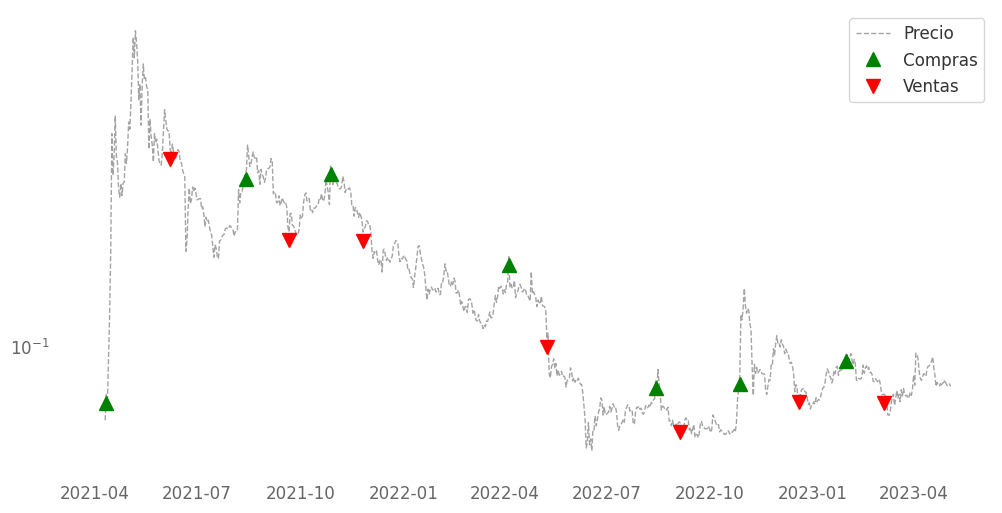

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


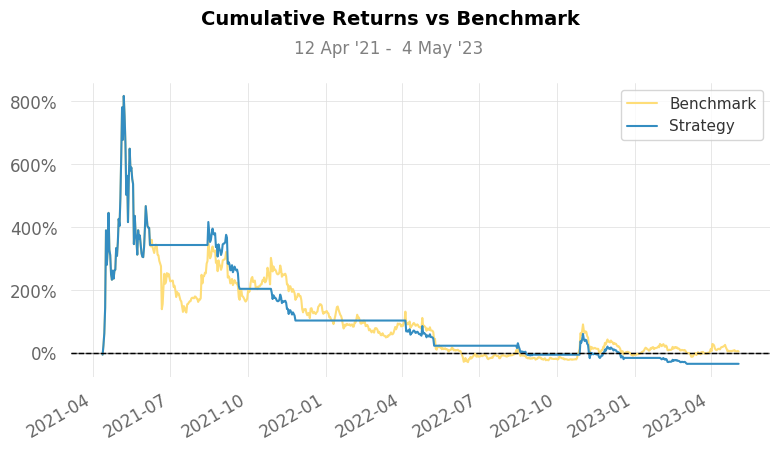

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


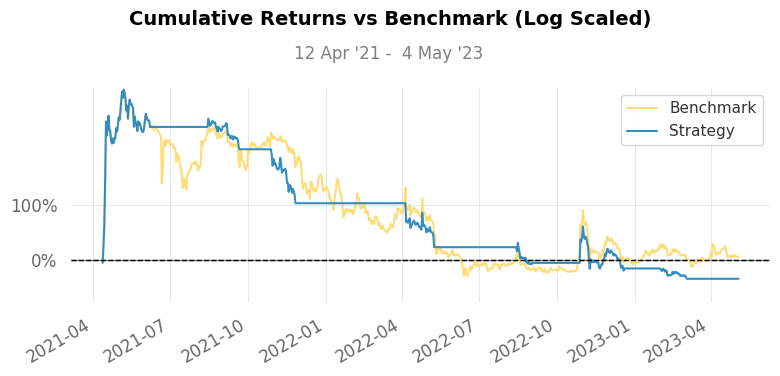

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


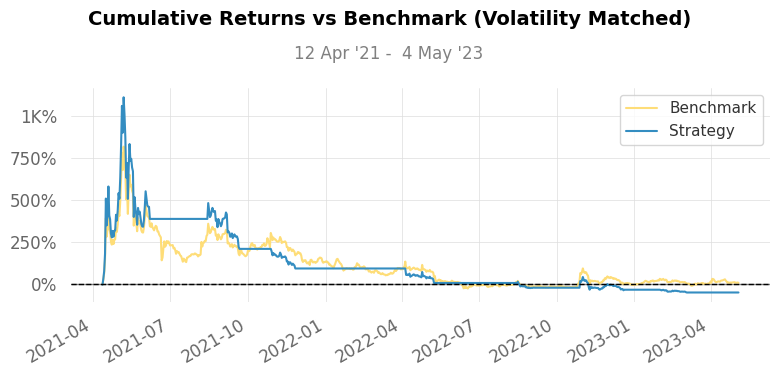

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


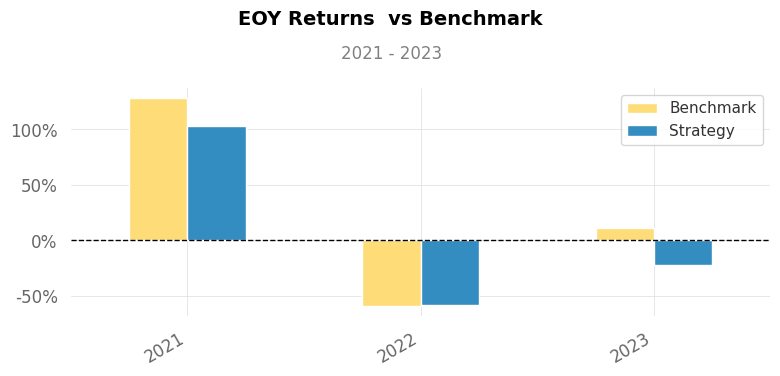

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


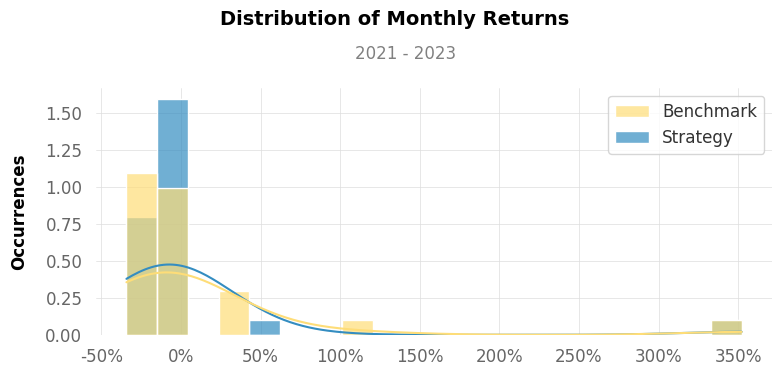

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


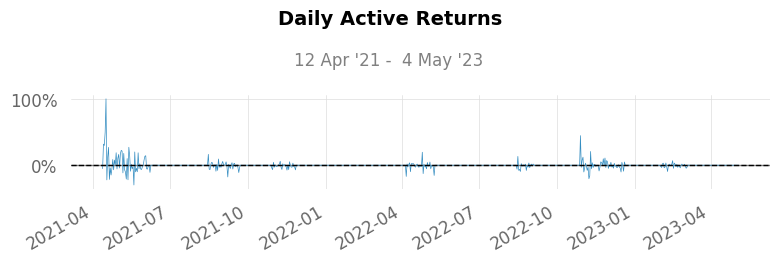

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


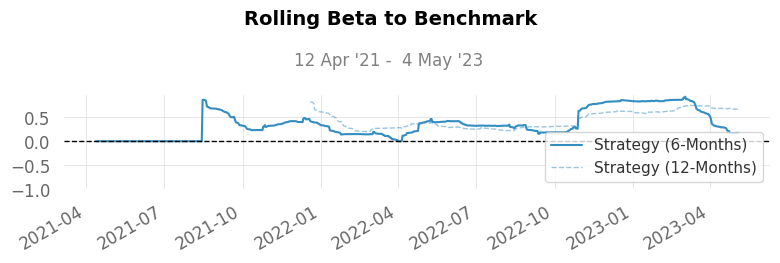

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


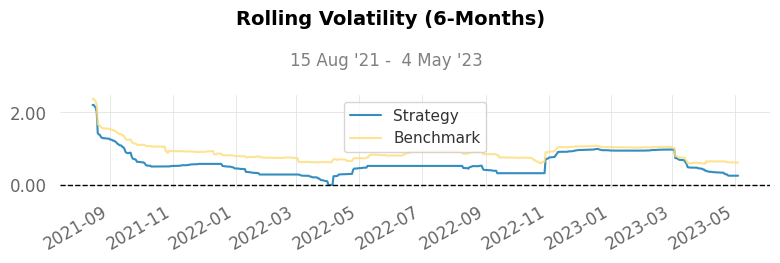

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


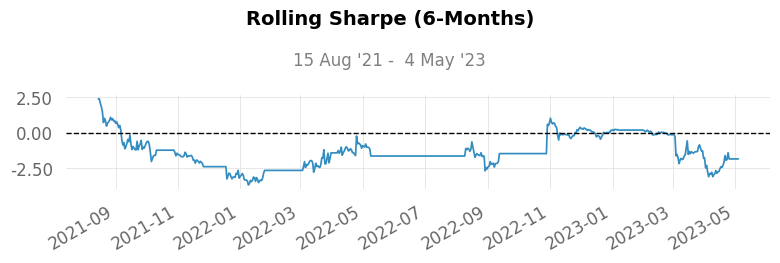

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


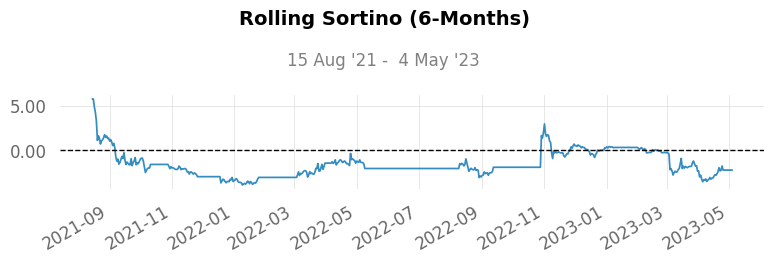

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


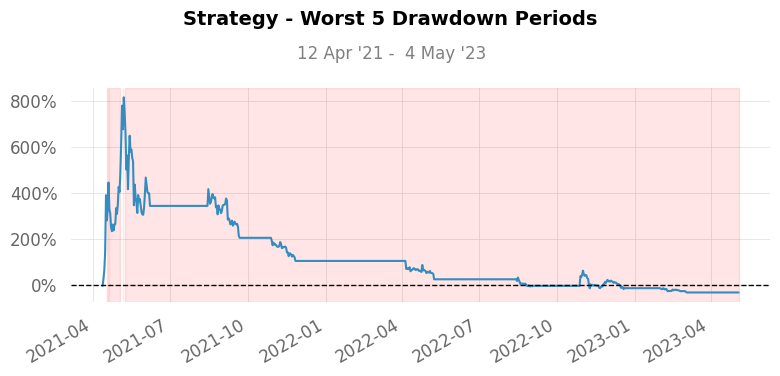

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


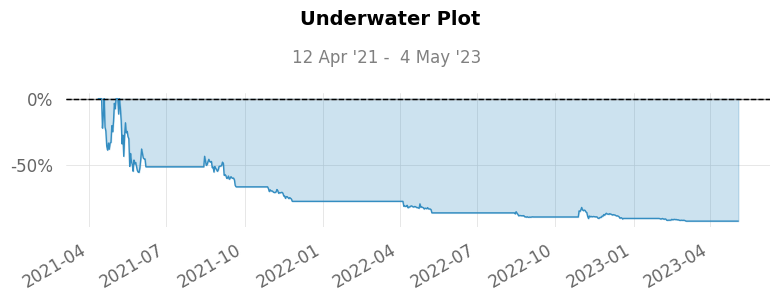

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


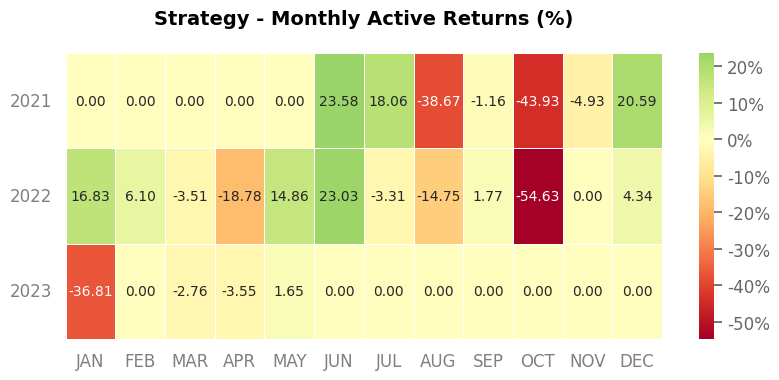

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


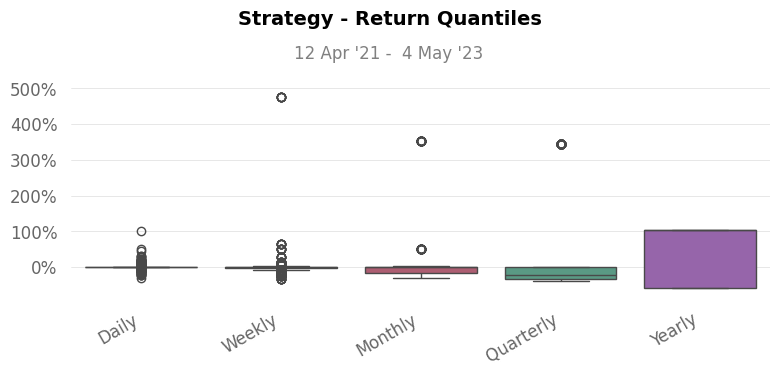

In [22]:
data = getData(ticker='SOL-USD',data_from='2021-01-01',data_to='2023-05-05')
features = getFeatures(data,n_obv=100,n_sigma=40,n_rsi=15,fast=20,slow=60)
actions = getActions(features,0,65,0.01,-0.01,55,0)
trades= getTrades(actions)
payoff = eventDriveLong(data)
results = payoff.iloc[:,-2:].add(1).cumprod()

df = data.iloc[:]
compras = actions.loc[actions.gatillo=='compra']
ventas = actions.loc[actions.gatillo=='venta']

fig,ax = plt.subplots(figsize=(12,6))

ax.plot(df.Close,'--k',alpha=0.4,lw=1,label='Precio')
ax.plot(compras.Close*0.95,marker='^',lw=0,markersize=10,color='green',label='Compras')
ax.plot(ventas.Close*0.95,marker='v',lw=0,markersize=10,color='red',label='Ventas')
ax.legend()
ax.set_yscale('log')
ax.grid(axis='both')


qs.reports.full(results['strategy'],benchmark=results['pct_change'])

<AxesSubplot: title={'center': 'Compare B&H vs Strategy'}, xlabel='Date'>

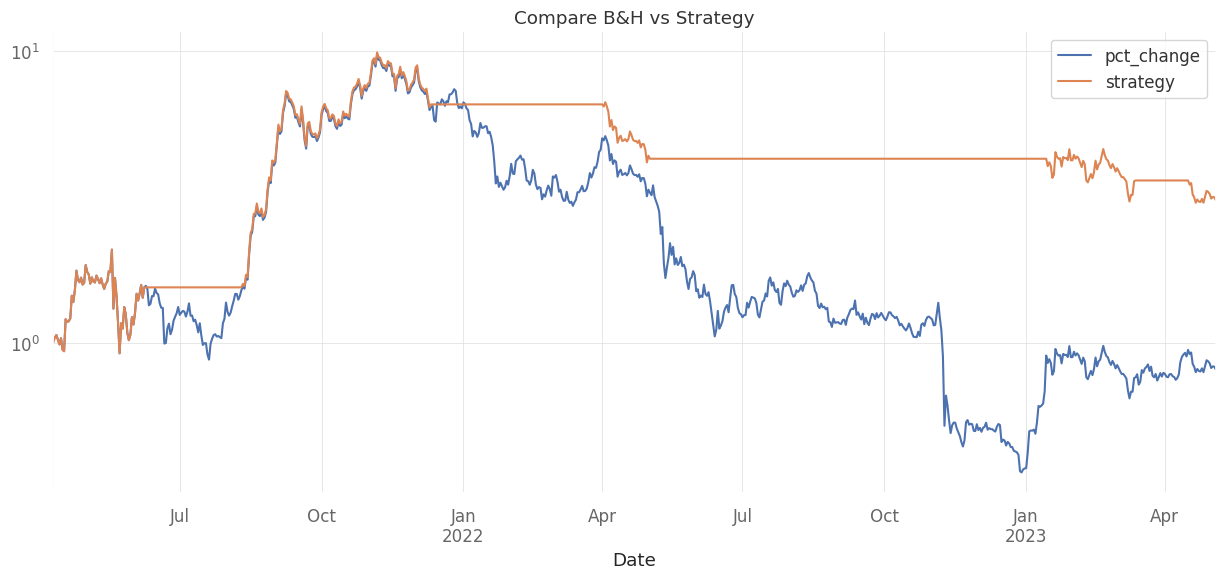

In [18]:
t = 'Compare B&H vs Strategy'
results.plot(figsize=(15,6),title=t,grid=True,logy=True)

Compra abierta


/home/ale/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


                           Benchmark    Strategy
-------------------------  -----------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Start Period               2021-04-12   2021-04-12
End Period                 2023-05-04   2023-05-04
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -52.08%      198,111,844,028,061,305,692,615,207,792,440,254,934,204,991,548,426,793,033,410,892,544,227,733,262,624,573,709,924,553,861,526,186,740,111,935,730,279,645,129,801,090,453,342,585,935,835,220,233,173,616,615,292,454,043,648.00%
CAGR﹪                     -21.85%      2.4663219904889156e+57%

Sharpe                     -0.16        96.25
Prob. Sharpe Ratio         38.92%       -
Smart Sharpe               -0.01        8.22
Sortino                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-04-14,2021-07-20,2023-05-04,751,-53.06185,-49.434732


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/home/ale/.local/lib/python3.10/site-packages/quantstats/_plotting/core.py:385: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


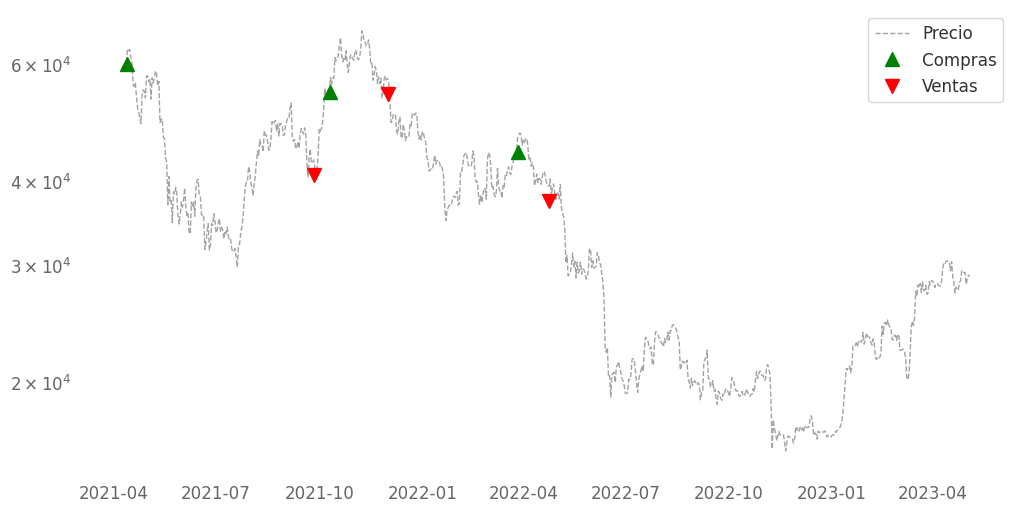

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


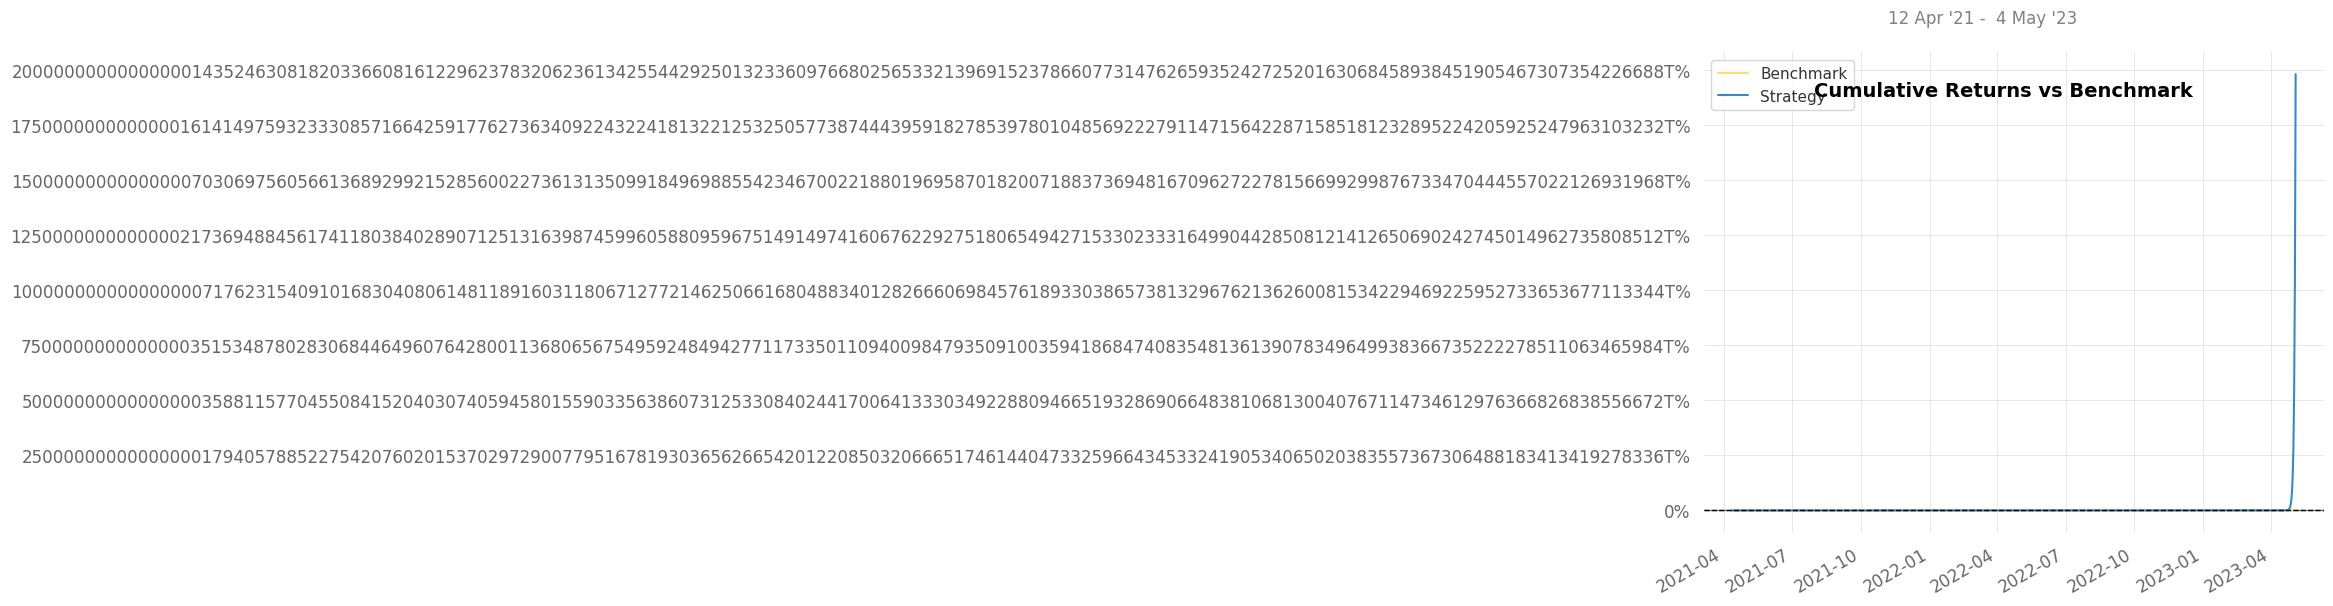

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


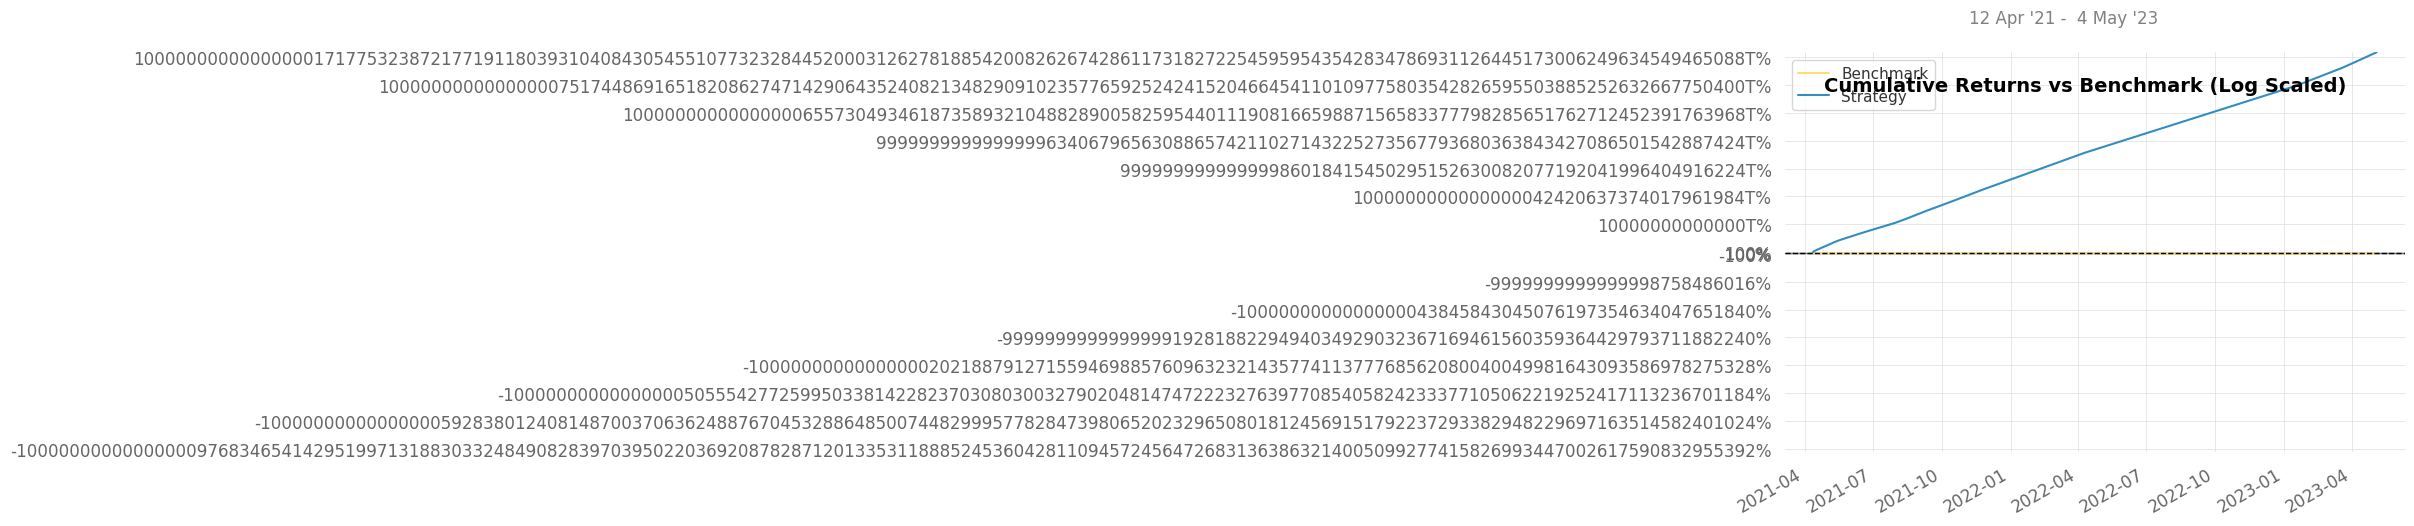

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


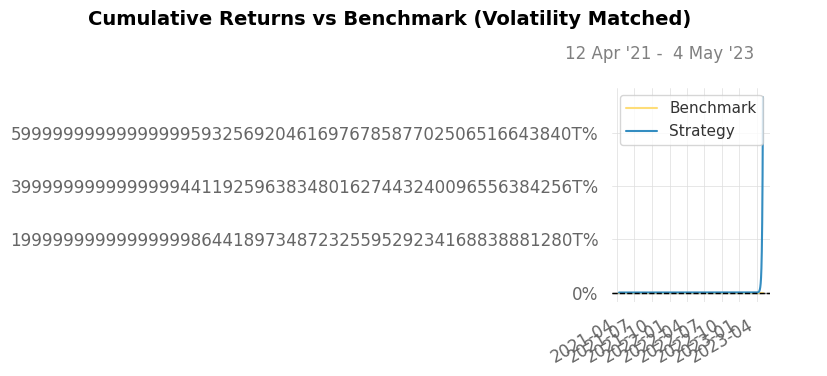

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


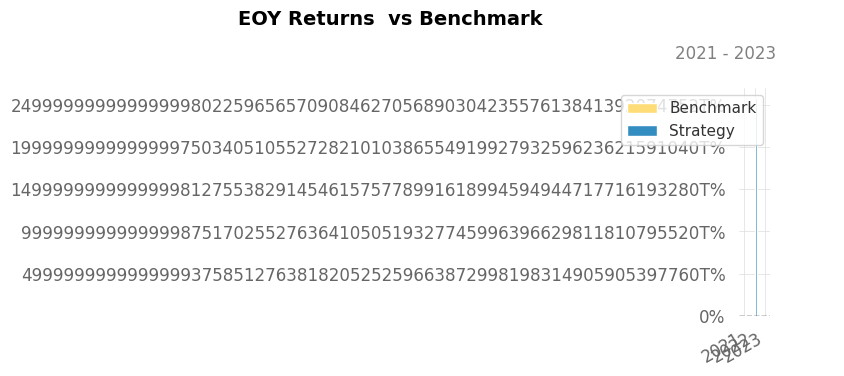

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


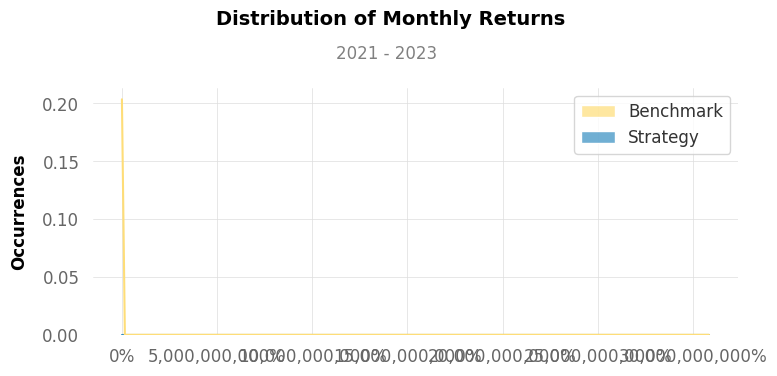

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


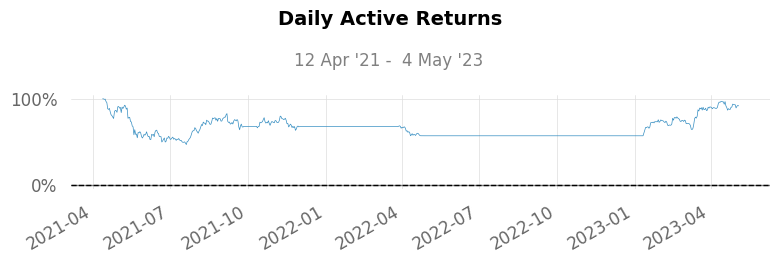

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


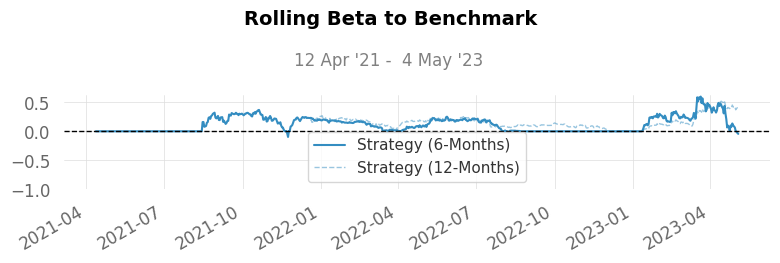

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


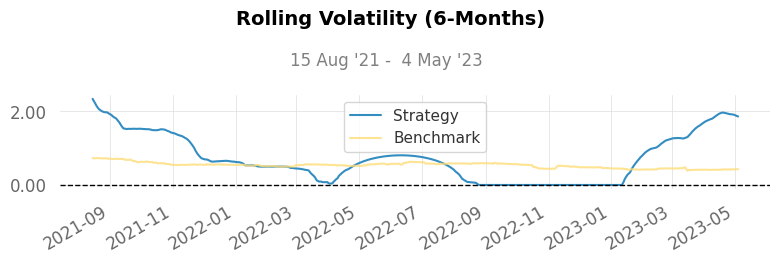

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


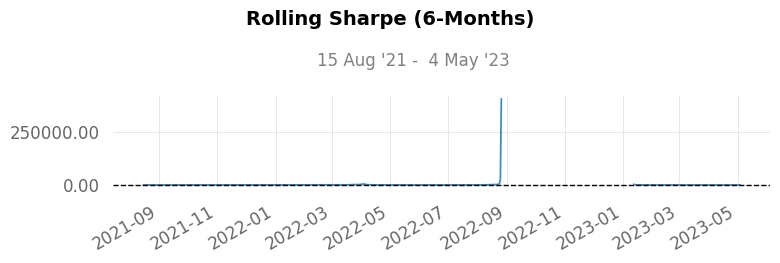

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


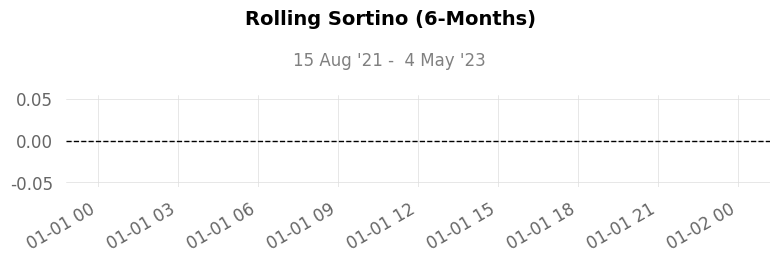

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/home/ale/.local/lib/python3.10/site-packages/quantstats/_plotting/core.py:971: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


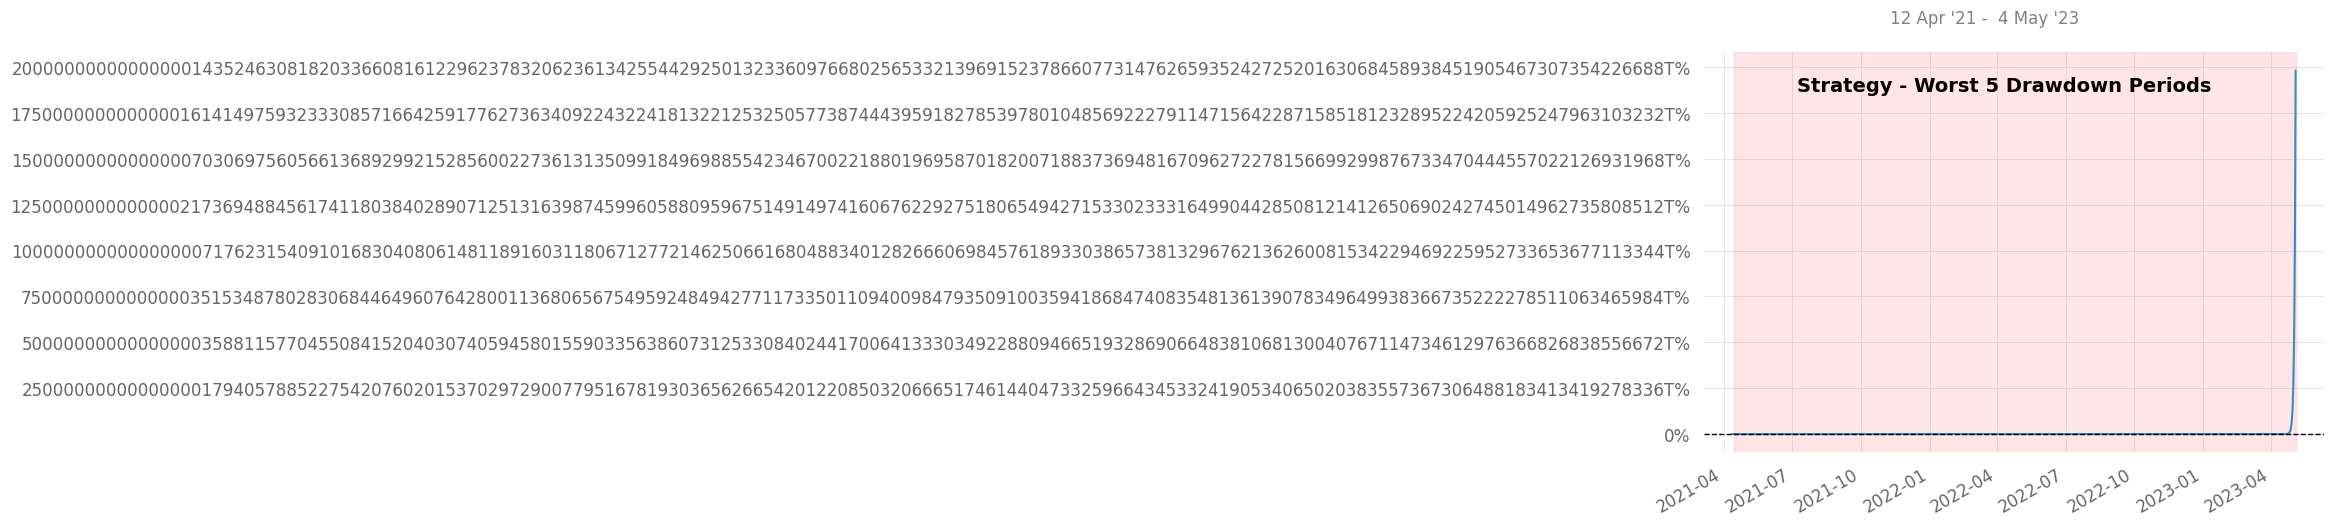

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


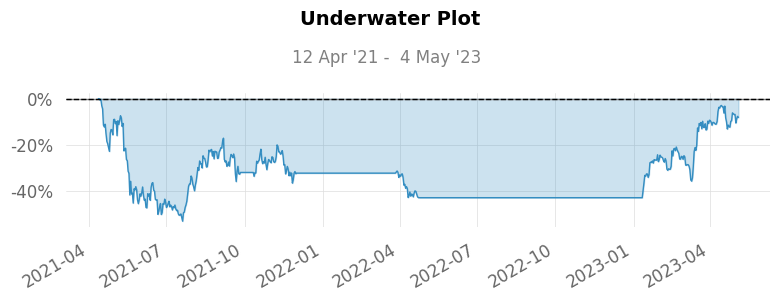

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


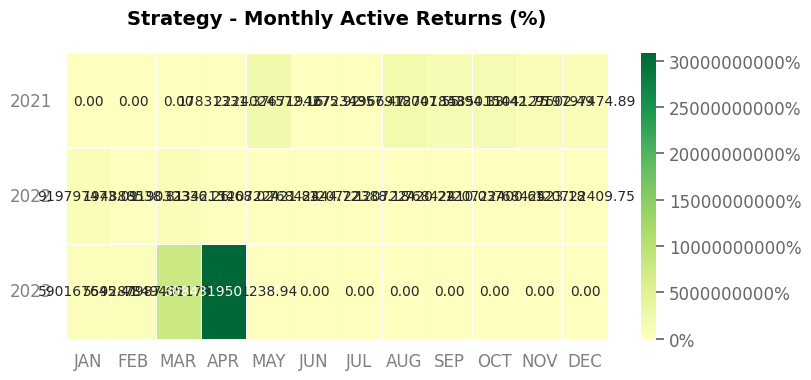

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
/home/ale/.local/lib/python3.10/site-packages/quantstats/_plotting/core.py:1084: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(w_pad=0, h_pad=0)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


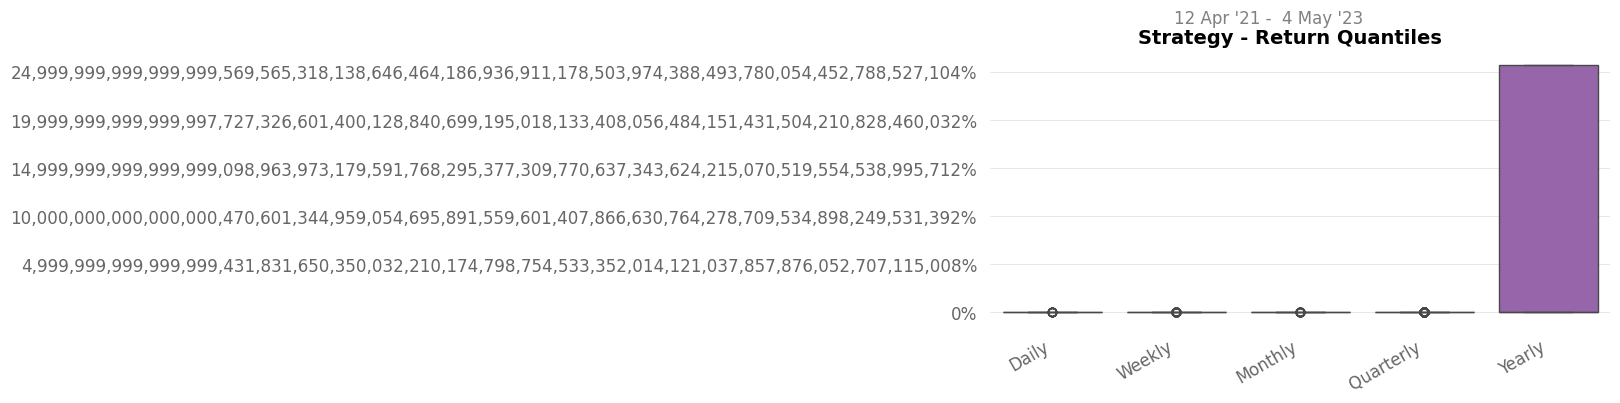

In [19]:
data = getData(ticker='BTC-USD',data_from='2021-01-01',data_to='2023-05-05')
features = getFeatures(data,n_obv=100,n_sigma=40,n_rsi=15,fast=20,slow=60)
actions = getActions(features,0,65,0.01,-0.01,55,0)
trades= getTrades(actions)
payoff = eventDriveLong(data)
results = payoff.iloc[:,-2:].add(1).cumprod()

df = data.iloc[:]
compras = actions.loc[actions.gatillo=='compra']
ventas = actions.loc[actions.gatillo=='venta']

fig,ax = plt.subplots(figsize=(12,6))

ax.plot(df.Close,'--k',alpha=0.4,lw=1,label='Precio')
ax.plot(compras.Close*0.95,marker='^',lw=0,markersize=10,color='green',label='Compras')
ax.plot(ventas.Close*0.95,marker='v',lw=0,markersize=10,color='red',label='Ventas')
ax.legend()
ax.set_yscale('log')
ax.grid(axis='both')


qs.reports.full(results['strategy'],benchmark=results['pct_change'])

<AxesSubplot: title={'center': 'Compare B&H vs Strategy'}, xlabel='Date'>

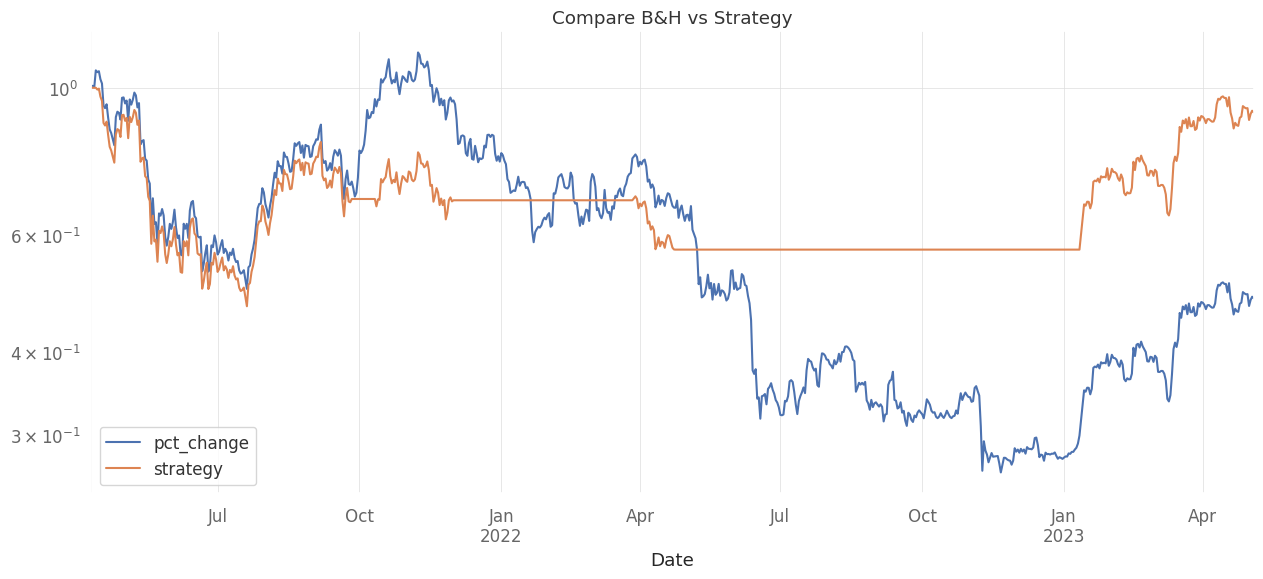

In [20]:
t = 'Compare B&H vs Strategy'
results.plot(figsize=(15,6),title=t,grid=True,logy=True)